In [9]:
from pyscf import gto, scf, cc
import numpy as np
from jax import numpy as jnp
from jax import vmap, jvp, jit
import jax
from functools import partial

a = 1.4 # 2aB
nH = 2
atoms = ""
for i in range(nH):
    atoms += f"N {i*a:.5f} 0.00000 0.00000 \n"

mol = gto.M(atom=atoms, basis="sto6g", unit='A', spin=0, verbose=4)
mol.build()

mf = scf.UHF(mol)
mf.kernel()

mo = mf.stability()[0]
dm = mf.make_rdm1(mo,mf.mo_occ)
mf.kernel(dm0=dm)
mo = mf.stability()[0]
dm = mf.make_rdm1(mo,mf.mo_occ)
mf.kernel(dm0=dm)


nfrozen = 0
mycc = cc.CCSD(mf,frozen=nfrozen)
mycc.kernel()
et = mycc.ccsd_t()
print(mycc.e_tot + et)

System: uname_result(system='Linux', node='sharmagroup-rn', release='6.14.0-37-generic', version='#37~24.04.1-Ubuntu SMP PREEMPT_DYNAMIC Thu Nov 20 10:25:38 UTC 2', machine='x86_64')  Threads 16
Python 3.11.14 (main, Oct 21 2025, 18:31:21) [GCC 11.2.0]
numpy 2.3.1  scipy 1.16.2  h5py 3.14.0
Date: Fri Jan 23 18:44:36 2026
PySCF version 2.11.0
PySCF path  /home/sharmagroup/sharmagroup/pyscf
GIT HEAD (branch master) 3d1768f5e33b144b606c3d2c81c12ee54d794501

[ENV] PYSCF_EXT_PATH /home/sharmagroup/sharmagroup/pyscf-forge
[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 2
[INPUT] num. electrons = 14
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = A
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 N      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.000000000000 Bohr 

In [17]:
# example for PT2
options = {'n_eql': 3,
           'n_prop_steps': 50,
            'n_ene_blocks': 1,
            'n_sr_blocks': 5,
            'n_blocks': 50,
            'n_walkers': 50,
            'seed': 2,
            'walker_type': 'uhf',
            'trial': 'uccsd_pt2',
            'dt':0.005,
            'free_projection':False,
            'ad_mode':None,
            'use_gpu': False,
            }

from ad_afqmc.prop_unrestricted import prop_unrestricted
prop_unrestricted.prep_afqmc(mycc,options,chol_cut=1e-5)
# prop_unrestricted.run_afqmc(options,nproc=1)
option_file='options.bin'
import pickle
with open(option_file, 'wb') as f:
    pickle.dump(options, f)

#
# Preparing AFQMC calculation
# If you import pyscf cc modules and use MPI for AFQMC in the same script, finalize MPI before calling the AFQMC driver.
# Calculating Cholesky integrals
# Finished calculating Cholesky integrals
#
# Size of the correlation space:
# Number of electrons: (7, 7)
# Number of basis functions: 10
# Number of Cholesky vectors: 39
#


In [3]:
import numpy as np
from jax import random
from jax import numpy as jnp
from functools import partial
from ad_afqmc import config, stat_utils
from ad_afqmc.prop_unrestricted import prop_unrestricted, sampling
import time

In [18]:
config.setup_jax()
MPI = config.setup_comm()
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

print = partial(print, flush=True)

ham_data, ham, prop, trial, wave_data, sampler, observable, options, _ = (
    prop_unrestricted._prep_afqmc())

init_time = time.time()
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

### initialize propagation
seed = options["seed"]
init_walkers = None
trial_rdm1 = trial.get_rdm1(wave_data)
if "rdm1" not in wave_data:
    wave_data["rdm1"] = trial_rdm1
ham_data = ham.build_measurement_intermediates(ham_data, trial, wave_data)
ham_data = ham.build_propagation_intermediates(ham_data, prop, trial, wave_data)
h0 = ham_data['h0']

prop_data = prop.init_prop_data(trial, wave_data, ham_data, init_walkers)
if jnp.abs(jnp.sum(prop_data["overlaps"])) < 1.0e-6:
    raise ValueError(
        "Initial overlaps are zero. Pass walkers with non-zero overlap."
    )
prop_data["key"] = random.PRNGKey(seed + rank)

prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
prop_data["n_killed_walkers"] = 0
# t, e0, te = trial.calc_energy_pt(
#     prop_data['walkers'], ham_data, wave_data)

# ept_sp = e0 + te - t*(e0-h0)

t1, t2, e0, e1 = trial.calc_energy_pt(prop_data["walkers"], ham_data, wave_data)
ept_sp = h0 + e0/t1 + e1/t1 - t2 * e0 / t1**2
ept = jnp.array(jnp.sum(ept_sp) / prop.n_walkers)
prop_data["e_estimate"] = ept
eci = trial.calc_energy(
    prop_data['walkers'], ham_data, wave_data)
prop_data["pop_control_ene_shift"] = prop_data["e_estimate"]

print(ept)
print(ept-mycc.e_tot)

# Hostname: sharmagroup-rn
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64
# Hostname: sharmagroup-rn
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64
# Number of MPI ranks: 1
#
# norb: 10
# nelec: (7, 7)
#
# n_eql: 3
# n_prop_steps: 50
# n_ene_blocks: 1
# n_sr_blocks: 5
# n_blocks: 50
# n_walkers: 50
# seed: 2
# walker_type: uhf
# trial: uccsd_pt2
# dt: 0.005
# free_projection: False
# use_gpu: False
# n_exp_terms: 6
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#
-108.66843557982834
2.115630310584038e-05


In [16]:
eris = mycc.ao2mo()
mf.e_tot + mycc.energy([mycc.t1[0]*0,mycc.t1[1]*0],mycc.t2,eris) - ept

Array(-2.10994217e-05, dtype=float64)

In [ ]:
comm.Barrier()
if rank == 0:
    print(f'# Propagating with {options["n_walkers"]*size} walkers')
    print("# Equilibration sweeps:")
    print("#   Iter \t Energy_HF \t Energy_PT \t Walltime")
    print(f"  {0:5d} \t {e0[0]:.6f} \t {ept:.6f} \t {time.time() - init_time:.2f}")
comm.Barrier()

sampler_eq = sampling.sampler_pt(
    n_prop_steps=50, n_ene_blocks=5, n_sr_blocks=10, n_chol = sampler.n_chol)
for n in range(1,options["n_eql"]+1):
    prop_data, (wt, t, e0, te) =\
        sampler_eq.propagate_phaseless(prop_data, ham_data, prop, trial, wave_data) 

    print(f"  {n:5d} \t {wt:.6f} \t {e0:.6f} \t {t:.6f} \t {te:.6f}")

In [7]:
nsamples = 50
wt_sp_list = np.empty(nsamples)
t_sp_list = np.empty(nsamples)
e0_sp_list = np.empty(nsamples)
te_sp_list = np.empty(nsamples)
ept_sp_list = np.empty(nsamples)
for i,n in enumerate(range(1,nsamples+1)):
    prop_data, (wt, t, e0, te) =\
        sampler.propagate_phaseless(prop_data, ham_data, prop, trial, wave_data)
    ept = e0 + te - t*(e0-h0)
    wt_sp_list[i] = wt
    t_sp_list[i] = t
    e0_sp_list[i] = e0
    te_sp_list[i] = te
    ept_sp_list[i] = ept
    prop_data["e_estimate"] = 0.9 * prop_data["e_estimate"] + 0.1 * ept
    prop_data["pop_control_ene_shift"] = prop_data["e_estimate"]
    print(f"  {n:5d} \t {wt:.6f} \t {e0:.6f} \t {t:.6f} \t {te:.6f} \t {ept:.6f}")

      1 	 249.014641 	 -108.617202 	 0.162179 	 -20.669652 	 -108.667710
      2 	 249.999846 	 -108.707364 	 0.200754 	 -25.500469 	 -108.666233
      3 	 249.299998 	 -108.645582 	 0.171759 	 -21.850295 	 -108.653793
      4 	 250.296452 	 -108.721286 	 0.228347 	 -29.000057 	 -108.665887
      5 	 249.991682 	 -108.730875 	 0.235515 	 -29.896528 	 -108.657638
      6 	 249.528179 	 -108.659291 	 0.190609 	 -24.238234 	 -108.655799
      7 	 248.954272 	 -108.608246 	 0.152662 	 -19.471327 	 -108.671735
      8 	 249.477072 	 -108.671459 	 0.193058 	 -24.573551 	 -108.689389
      9 	 249.306486 	 -108.655779 	 0.194125 	 -24.689009 	 -108.656546
     10 	 249.773599 	 -108.687008 	 0.210469 	 -26.741281 	 -108.654913
     11 	 249.201422 	 -108.618866 	 0.161947 	 -20.635610 	 -108.664510
     12 	 250.092468 	 -108.738019 	 0.240549 	 -30.545121 	 -108.671122
     13 	 249.007013 	 -108.621070 	 0.162110 	 -20.656629 	 -108.666705
     14 	 248.589568 	 -108.598735 	 0.140162 	 -17

AFQMC/HF average = -108.63794290705981, std = 0.006273447896687498
AFQMC/PT average = -108.66365812823686, std = 0.0009793696530951974


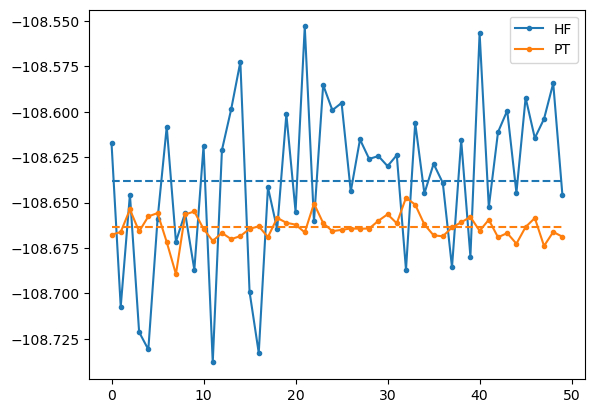

In [8]:
from matplotlib import pyplot as plt
e0_avg = e0_sp_list.mean()
e0_avg_std = np.std(e0_sp_list, ddof=1) / np.sqrt(len(e0_sp_list))
ept_avg = ept_sp_list.mean()
ept_avg_std = np.std(ept_sp_list, ddof=1) / np.sqrt(len(ept_sp_list))
print(f'AFQMC/HF average = {e0_avg}, std = {e0_avg_std}')
print(f'AFQMC/PT average = {ept_avg}, std = {ept_avg_std}')
plt.plot(e0_sp_list,'.-',label='HF',color='C0')
plt.plot([e0_avg]*len(e0_sp_list),'--',color='C0')
plt.plot(ept_sp_list,'.-',label='PT',color='C1')
plt.plot([ept_avg]*len(ept_sp_list),'--',color='C1')
plt.legend()
plt.show()

In [23]:
glb_wt = np.sum(wt_sp_list)

glb_t = np.sum(wt_sp_list * t_sp_list) / glb_wt
glb_e0 = np.sum(wt_sp_list * e0_sp_list) / glb_wt
glb_te = np.sum(wt_sp_list * te_sp_list) / glb_wt

glb_ept = glb_e0 + glb_te - glb_t * (glb_e0 - h0)
dE = np.array([-glb_e0+h0,1-glb_t,1])
cov_te0e1 = np.cov([t_sp_list, e0_sp_list, te_sp_list])
ept_cov = np.sqrt(dE @ cov_te0e1 @ dE)/np.sqrt((n+1)*size)

print(f'AFQMC/PT glb cov = {glb_ept:.4f} +/- {ept_cov:.4f}')

AFQMC/PT glb cov = -108.6649 +/- 0.0010


In [25]:
wt_list = wt_sp_list
wt_t_list = wt_sp_list * t_sp_list
wt_e0_list = wt_sp_list * e0_sp_list
wt_te_list = wt_sp_list * te_sp_list

In [29]:
blk_size = 2
blk_wt_list = wt_list.reshape(-1, blk_size).sum(axis=1)
blk_wt_t_list = wt_t_list.reshape(-1, blk_size).sum(axis=1)
blk_wt_e0_list = wt_e0_list.reshape(-1, blk_size).sum(axis=1)
blk_wt_te_list = wt_te_list.reshape(-1, blk_size).sum(axis=1)

blk_t_list = blk_wt_t_list / blk_wt_list
blk_e0_list = blk_wt_e0_list / blk_wt_list
blk_te_list = blk_wt_te_list / blk_wt_list

In [30]:
glb_wt = np.sum(blk_wt_list)
glb_t = np.sum(blk_wt_list * blk_wt_t_list) / glb_wt
glb_e0 = np.sum(blk_wt_list * blk_wt_e0_list) / glb_wt
glb_te = np.sum(blk_wt_list * blk_wt_te_list) / glb_wt

glb_ept = glb_e0 + glb_te - glb_t * (glb_e0 - h0)
dE = np.array([-glb_e0+h0,1-glb_t,1])
cov_te0e1 = np.cov([blk_t_list, blk_e0_list, blk_te_list])
ept_cov = np.sqrt(dE @ cov_te0e1 @ dE)/np.sqrt((n+1)*size)

print(f'AFQMC/PT glb cov = {glb_ept:.4f} +/- {ept_cov:.4f}')

AFQMC/PT glb cov = 4646803.6558 +/- 149.0173


In [ ]:
blk_size = 2
blk_wt_list = wt_list.reshape(-1, blk_size)
blk_wt_t_list = wt_t_list.reshape(-1, blk_size)
blk_wt_e0_list = wt_e0_list.reshape(-1, blk_size)
blk_wt_te_list = wt_te_list.reshape(-1, blk_size)

glb_ept = glb_e0 + glb_te - glb_t * (glb_e0 - h0)
dE = np.array([-glb_e0+h0,1-glb_t,1])
cov_te0e1 = np.cov([t_sp_list, e0_sp_list, te_sp_list])
ept_cov = np.sqrt(dE @ cov_te0e1 @ dE)/np.sqrt((n+1)*size)

print(f'AFQMC/PT glb cov = {glb_ept:.4f} +/- {ept_cov:.4f}')

In [16]:
rho_e0

array([-2.17098876, -2.18138733, -2.1740445 , -2.18425509, -2.18178787,
       -2.17630894, -2.17028348, -2.17610686, -2.17430512, -2.1790051 ,
       -2.17265045, -2.18281089, -2.17099958, -2.16691435, -2.16798792,
       -2.17630962, -2.18695648, -2.17671218, -2.17556064, -2.17042271,
       -2.1768688 , -2.16145153, -2.17078216, -2.16445097, -2.16926911,
       -2.16719207, -2.17612613, -2.16913996, -2.17393945, -2.16948587,
       -2.16672907, -2.16971558, -2.17847985, -2.16862898, -2.1729198 ,
       -2.17218209, -2.17046066, -2.18233159, -2.17202735, -2.17522561,
       -2.16415297, -2.17442972, -2.17052904, -2.16923439, -2.17010375,
       -2.16813818, -2.17140207, -2.1680249 , -2.16571808, -2.17308923])

In [ ]:
rn_rho_e0 = rho_e0.reshape(-1, 2).mean(axis=1)
print(rn_rho_e0.sum())

-54.31901342780237
